<a href="https://colab.research.google.com/github/Arunav07/CRISTL-Project-1/blob/Atharva_D's-Branch/try_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [13]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import natsort
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# import tensorflow.keras.utils.to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import UnidentifiedImageError
import skimage.io
import skimage.color
import skimage.filters
import io
from skimage import data, io, img_as_ubyte
from skimage.filters import threshold_multiotsu
# from tensorflow.python.keras.preprocessing.image import img_to_array
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from google.colab.patches import cv2_imshow

In [6]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [7]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [8]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [9]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [23]:
Labels_Data = pd.read_csv("/content/AutomatedLabelFile.csv")
Labels_Data.shape

(663, 11)

In [29]:
Images = glob.glob("/content/gdrive/MyDrive/IDD_Detection/JPEGImages/highquality_16k/15-07-18-upload/*.jpg")

In [30]:
X_train, X_val, y_train_bin, y_val_bin = train_test_split(Images, Labels_Data, random_state=42, test_size=0.2)

In [31]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [32]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [33]:
feature_extractor_layer.trainable = False

In [34]:

model = tf.keras.Sequential([
    feature_extractor_layer,
    Dense(1024, activation='relu', name='hidden_layer'),
    Dense(11, activation='sigmoid', name='output')
])

In [35]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [36]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [37]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss="binary_crossentropy",
  metrics=["accuracy"])

In [38]:
history = model.fit(train_ds,
  epochs=EPOCHS,
  validation_data=create_dataset(X_val, y_val_bin))

Epoch 1/30
3/3 [==============================] - 23s 2s/step - loss: 0.7560 - accuracy: 0.0094 - val_loss: 0.7299 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 248ms/step - loss: 0.7212 - accuracy: 0.0189 - val_loss: 0.6971 - val_accuracy: 0.0150
Epoch 3/30
3/3 [==============================] - 1s 249ms/step - loss: 0.6895 - accuracy: 0.0226 - val_loss: 0.6672 - val_accuracy: 0.0226
Epoch 4/30
3/3 [==============================] - 1s 245ms/step - loss: 0.6601 - accuracy: 0.0264 - val_loss: 0.6399 - val_accuracy: 0.0226
Epoch 5/30
3/3 [==============================] - 1s 248ms/step - loss: 0.6335 - accuracy: 0.0340 - val_loss: 0.6150 - val_accuracy: 0.0301
Epoch 6/30
3/3 [==============================] - 1s 244ms/step - loss: 0.6088 - accuracy: 0.0396 - val_loss: 0.5925 - val_accuracy: 0.0376
Epoch 7/30
3/3 [==============================] - 1s 245ms/step - loss: 0.5868 - accuracy: 0.0415 - val_loss: 0.5723 - val_accuracy: 0.0376
Epoch 8/30
3/3 [==

In [40]:
img = image.load_img( '/content/gdrive/MyDrive/IDD_Detection/JPEGImages/highquality_16k/15-07-18-upload/0004627.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

car (0.9208)
rider (0.91654)
motorcycle (0.80048)
autorickshaw (0.79374)
vehicle_fallback (0.78857)
person (0.74933)
truck (0.63069)
bus (0.59058)
traffic_sign (0.51291)
bicycle (0.099243)
animal (0.088932)


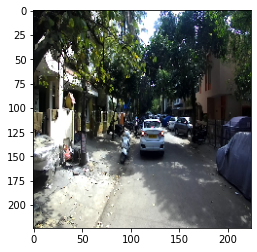

In [48]:
classes = np.array(Labels_Data.columns[:])
proba = model.predict(img.reshape(1,224,224,3))
top_11 = np.argsort(proba[0])[::-1]
for i in range(11):
    print("{}".format(classes[top_11[i]])+" ({:.5})".format(proba[0][top_11[i]]))
plt.imshow(img)

In [57]:
img = image.load_img( '/content/gdrive/MyDrive/IDD_Detection/JPEGImages/highquality_16k/BLR-2018-06-06_16-20-12/0007277.jpg',target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255

car (0.95678)
motorcycle (0.88535)
rider (0.88257)
autorickshaw (0.80817)
person (0.79569)
vehicle_fallback (0.78384)
truck (0.54027)
bus (0.45579)
traffic_sign (0.32994)
bicycle (0.11388)
animal (0.046871)


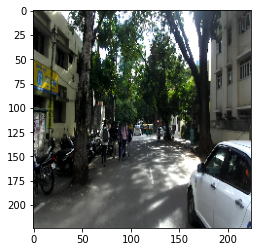

In [58]:
classes = np.array(Labels_Data.columns[:])
proba = model.predict(img.reshape(1,224,224,3))
top_11 = np.argsort(proba[0])[::-1]
for i in range(11):
    print("{}".format(classes[top_11[i]])+" ({:.5})".format(proba[0][top_11[i]]))
plt.imshow(img)